In [9]:
import os
from dotenv import load_dotenv
from typing import TypedDict

from langgraph.graph import StateGraph, START, END

In [3]:
load_dotenv()
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

#### Sequential Workflow


###### Example 01


In [4]:
# Define State
class BMIState(TypedDict):
    weight_kg: float
    height_m: float
    bmi: float

In [13]:
def calculate_bmi(state: BMIState) -> BMIState:
    weight = state['weight_kg']
    height = state['height_m']

    bmi = weight / (height ** 2)
    state['bmi'] = round(bmi, 2)

    return state

In [14]:
# STEP 1: Define Graph
graph = StateGraph(BMIState)

# STEP 2: Add nodes to the graph
NODE_CALCULATE_BMI = 'calculate_bmi'
graph.add_node(NODE_CALCULATE_BMI, calculate_bmi)

# STEP 3: Add edges to the graph
graph.add_edge(START, NODE_CALCULATE_BMI)
graph.add_edge(NODE_CALCULATE_BMI, END)


# STEP 4: Compile the graph
workflow = graph.compile()

In [15]:
# STEP 5: Execute the graph

# Define initial state
initial_state = {
    'weight_kg': 82,
    'height_m': 1.75
}

final_state = workflow.invoke(initial_state)
final_state

{'weight_kg': 82, 'height_m': 1.75, 'bmi': 26.78}

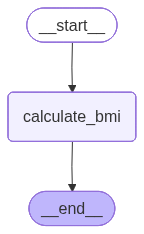

In [16]:
# View the compiled graph
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())

###### Example 02


In [17]:
# Define State
class BMIState(TypedDict):
    weight_kg: float
    height_m: float
    bmi: float
    category: str

In [26]:
# Define functions

def calculate_bmi(state: BMIState) -> BMIState:
    weight = state['weight_kg']
    height = state['height_m']

    bmi = weight / (height ** 2)
    state['bmi'] = round(bmi, 2)

    return state


def label_bmi(state: BMIState) -> BMIState:
    bmi = state['bmi']

    if bmi < 18.5:
        state['category'] = 'Underweight'
    elif 18.5 <= bmi < 25:
        state['category'] = 'Normal'
    elif 25 <= bmi < 30:
        state['category'] = 'Overweight'
    else:
        state['category'] = 'Obese'

    return state

In [27]:
# STEP 1: Define Graph
graph = StateGraph(BMIState)

# STEP 2: Add nodes to the graph
NODE_CALCULATE_BMI = 'calculate_bmi'
NODE_LABEL_BMI = 'label_bmi'

graph.add_node(NODE_CALCULATE_BMI, calculate_bmi)
graph.add_node(NODE_LABEL_BMI, label_bmi)

# STEP 3: Add edges to the graph
graph.add_edge(START, NODE_CALCULATE_BMI)
graph.add_edge(NODE_CALCULATE_BMI, NODE_LABEL_BMI)
graph.add_edge(NODE_LABEL_BMI, END)


# STEP 4: Compile the graph
workflow = graph.compile()

In [28]:
# STEP 5: Execute the graph
initial_state = {
    'weight_kg': 82,
    'height_m': 1.75
}

final_state = workflow.invoke(initial_state)
final_state

{'weight_kg': 82, 'height_m': 1.75, 'bmi': 26.78, 'category': 'Overweight'}

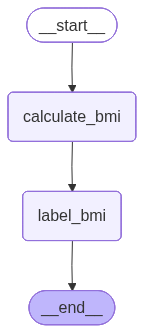

In [29]:
# View the compiled graph
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())

###### Example 03 (LLM Workflow)


In [30]:
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END, START
from typing import TypedDict

In [35]:
model = ChatOpenAI()

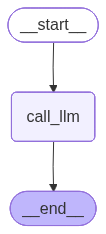

In [36]:
# STEP 1: Define State
class LLMState(TypedDict):
    question: str
    answer: str


# STEP 2: Define Graph
graph = StateGraph(LLMState)

# STEP 3: Add nodes to the graph
NODE_CALL_LLM = 'call_llm'


def llm_qa(state: LLMState) -> LLMState:
    # Extract the question from state
    question = state['question']

    # Form a prompt
    prompt = f'Answer the following question: {question}'

    model = ChatOpenAI()

    # Ask the question to the LLM
    response = model.invoke(prompt)

    # Update the answer in the state
    state['answer'] = response.content

    return state


graph.add_node(NODE_CALL_LLM, llm_qa)


# STEP 4: Add edges to the graph
graph.add_edge(START, NODE_CALL_LLM)
graph.add_edge(NODE_CALL_LLM, END)


# STEP 5: Compile the graph
workflow = graph.compile()
workflow

In [37]:
# STEP 6: Execute the graph
initial_state = {
    'question': 'How far is moon from the earth ?',
}

final_state = workflow.invoke(initial_state)
final_state

{'question': 'How far is moon from the earth ?',
 'answer': 'The average distance from the Earth to the Moon is approximately 384,400 kilometers (238,855 miles).'}

###### Example 04 (Prompt Chaining - Series of LLM Call)


In [44]:
import os
from dotenv import load_dotenv
from typing import TypedDict
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END

load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
model = ChatOpenAI()

In [54]:
# Define the state
class BlogState(TypedDict):
    title: str
    outline: str
    content: str
    rating: str

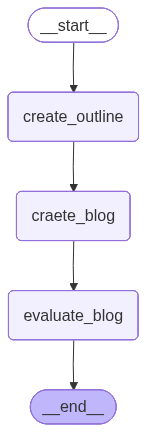

In [52]:
# Define Graph
graph = StateGraph(BlogState)

# Add nodes
NODE_CREATE_OUTLINE = 'create_outline'
NODE_CREATE_BLOG = 'craete_blog'
NODE_EVALUATE_BLOG = 'evaluate_blog'


def create_outline(state: BlogState) -> BlogState:
    title = state['title']

    prompt = f'Generate a detailed outline for a blog on the topic: {title}'
    response = model.invoke(prompt)

    state['outline'] = response.content
    return state


def create_blog(state: BlogState) -> BlogState:
    outline = state['outline']
    title = state['title']

    prompt = f'Write a detailed blog in the title - {title} using the following outline\n{outline}'

    response = model.invoke(prompt)

    state['content'] = response.content
    return state


def evaluate_blog(state: BlogState) -> BlogState:
    outline = state['outline']
    content = state['content']

    prompt = f'Based on the following outline: {outline}\nRate the blog: {content}'

    response = model.invoke(prompt)
    state['rating'] = response.content
    return state


graph.add_node(NODE_CREATE_OUTLINE, create_outline)
graph.add_node(NODE_CREATE_BLOG, create_blog)
graph.add_node(NODE_EVALUATE_BLOG, evaluate_blog)

# Add edges
graph.add_edge(START, NODE_CREATE_OUTLINE)
graph.add_edge(NODE_CREATE_OUTLINE, NODE_CREATE_BLOG)
graph.add_edge(NODE_CREATE_BLOG, NODE_EVALUATE_BLOG)
graph.add_edge(NODE_EVALUATE_BLOG, END)

# Compile the graph
workflow = graph.compile()
workflow

In [53]:
# Execute
initial_state = {
    'title': 'Rise of AI in India'
}

final_state = workflow.invoke(initial_state)

# print(f'TITLE: {final_state['title']}\n')
# print(f'OUTLINE:\n{final_state['outline']}\n\n')
# print(f'Blog:\n{final_state['content']}')
print(f'Rating: {final_state['rating']}')

Rating: Overall, I would rate this blog highly as it covers a comprehensive overview of the rise of AI in India. It addresses key points such as the current state of AI in India, driving factors, challenges, impact on the economy, future projections, and successful case studies. The inclusion of government initiatives, major players, and the skilled workforce in India adds depth to the analysis. The structure of the blog is clear and organized, making it easy for readers to follow along. The call to action at the end encourages engagement and further exploration of AI developments in India. I would rate this blog a 9 out of 10 for its informative content and relevance in today's tech-driven landscape.


#### Parallel Workflow


###### Example 01

###### Example 02

###### Example 03

#### Conditional Workflow


#### Iterative Workflow


#### Pass
